# Text EDA for Lululemon's Subreddit

In this notebook, we undergo some basic text exploratory analysis for the posts and comments we extracted from the lululemon subreddit.

## Preliminaries

In [1]:
# Imports

import matplotlib.pyplot as plt
import re, pandas as pd
import numpy as np
import time
from datetime import datetime, timezone


# NLP
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
import nltk, pprint
# pprint.pp(nltk.data.path)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import names

In [3]:
# Set user's data path

PATH = f"C:/Users/emshe/Desktop/BRAINSTATION/LULULEMON/DATA"

## Helper Functions

In [4]:
# Function to examine dataframes

def examine_df(name: str, 
                 df: pd.DataFrame,
      include_stats: bool = True,
     include_sample: bool = True):
    
    """
    Check basic info about a dataframe df
    """
    
    print(f"\n\nNumber of records in the {name} is: {len(df)}\n")
    print(f"\nNumber of features in the {name} is: {len(df.columns)}\n")
    print(f"The columns in the {name} are: {df.columns}\n")
    print(f"\n Other info about {name}:\n")
    display(df.info())
    if include_stats == True:
        print(f'\n Basic statistical info about {name}:\n')
        display(df.describe())
    if include_sample == True:
        print(f"\n\nSample of records in the {name}:")
        display(df.head(5))

In [5]:
# Function to get sample from text column

# Ensure pandas doesn't truncate text
pd.set_option('display.max_colwidth', None)


def get_text_samples(df: pd.DataFrame, text_col: str, n: int) -> None:

    '''
    Print n samples from a text column in a dataframe
    '''

    # Sample and print 5 full negative reviews
    print("Sample text data:\n\n")
    sample = df[text_col].sample(n)
    for i, description in enumerate(sample, 1):
        print(f"Text sample {i}:\n\n\n{description}\n\n\n")

In [42]:
# Function for categorical bar graph

def bar_graph(df: pd.DataFrame, col: str) -> None:

    """
    Generate bar graph for categorical column in a dataframe
    """

    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in dataframe")

    counts = posts_df[col].value_counts()
    
    plt.figure(figsize=(10,6))
    counts.plot(kind="bar")
    plt.title(f"Distribution of {col.title()}")
    plt.xlabel(f"{col.title()}")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [52]:
# Define function to plot histogram for numeric columns

def histogram(df: pd.DataFrame, 
             col: str,
            bins: int = 30,
             log: bool = False) -> None:
    
    """
    Generate a histogram for a numeric column in a dataframe.
    """
    
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in dataframe")
    
    plt.figure(figsize=(8, 5))
    df[col].dropna().hist(bins=bins, edgecolor="black", log=log)
    plt.title(f"Histogram of {col.title()}")
    plt.xlabel(col.title())
    plt.ylabel("Log(Frequency)" if log else "Frequency")
    plt.tight_layout()
    plt.show()

## Initial Inspection

In [6]:
# Load dataframe of all posts

posts_df = pd.read_csv(f"{PATH}/posts.csv")
posts_df["timestamp"] = pd.to_datetime(posts_df["timestamp"], errors="coerce")

examine_df('posts dataframe', posts_df)



Number of records in the posts dataframe is: 1593


Number of features in the posts dataframe is: 12

The columns in the posts dataframe are: Index(['post_id', 'timestamp', 'author', 'title', 'text', 'score',
       'num_comments', 'link_flair_text', 'permalink', 'stickied', 'locked',
       'upvote_ratio'],
      dtype='object')


 Other info about posts dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1593 entries, 0 to 1592
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   post_id          1593 non-null   object             
 1   timestamp        1593 non-null   datetime64[ns, UTC]
 2   author           1530 non-null   object             
 3   title            1593 non-null   object             
 4   text             1309 non-null   object             
 5   score            1593 non-null   int64              
 6   num_comments     1593 non-null   int64              

None


 Basic statistical info about posts dataframe:



,score,num_comments,upvote_ratio
count,1593.000000,1593.000000,995.000000
mean,369.907721,35.849341,0.853698
std,1333.332917,49.496192,0.160594
min,0.000000,0.000000,0.130000
25%,25.000000,7.000000,0.790000
50%,120.000000,18.000000,0.920000
75%,544.000000,44.000000,0.970000
max,49047.000000,438.000000,1.000000




Sample of records in the posts dataframe:


,post_id,timestamp,author,title,text,score,num_comments,link_flair_text,permalink,stickied,locked,upvote_ratio
0,1n7q2s8,2025-09-03 20:31:13+00:00,berry_pink,Price change in a few days and bad CSR,"I was shopping for a new skirt as a treat-yo-self and I saw the new Side-Pleat High-Rise Tennis Skirt. The red one priced at $98 but as it was a TYS purchase I decided to get it along with 3 other items. I got a notice that my item was shipped but awaiting carrier pick-up but that lasted so many days which is unusual for lulu. I contacted Lululemon to inquire and they said it was lost. They would refund me but seeing that the price has increased by then dollars for the skirt, I asked if they would just replace the order. The CSR said they need 100 items in order for a replacement to happen but it's available online. After some arm twisting, she put the order threw but told me that there was a good chance my order would get cancelled. I shop a lot at Lululemon and lately I feel like the customer service has been going way down. We pay a lot of money for the clothes and it just left a bad taste that I had to so much coaxing to get a reorder on a lost shipment because they use a bad carrier. Fingers crossed I actually get the celebratory skirt I ordered.",2,0,Discussion,https://www.reddit.com/r/lululemon/comments/1n7q2s8/price_change_in_a_few_days_and_bad_csr/,False,False,1.00
1,1n7po2x,2025-09-03 20:16:03+00:00,runandplay2,In Store Try On (Rockwood / New define Track that jacket / WT leopard) 🐆 🧨🫒,"Sorry for the double post today but thought others would want to see the try on. I was so curious to see rockwood in person. Seems very true to online. It is a gorgeous jewel tone. The new define track that jacket was actually so much better in person. I loved it. It feels like a mix between the define and scuba with how it feels and fits. My big issue with it is there are two zippers and the bottom zipper ends in a weird spot for me. So I passed but if you get it, I’d size down. I first tried a 4 and it was pretty big so switched to a 2. I was disappointed with the WT leopard print in person. It was so hard to see and the material felt stiff. I think the sequoia WTs are much prettier so I skipped the print. Rockwood Cropped Define (4) Rockwood Align 6in shorts (2) Paired with the bra I had on — Lavender Frost Focuser Scoop neck Olive Brown / Black Define Track that jacket (2) Leopard Shift Micro Embossed Brown WT leggings (2) Rockwood Scuba joggers (xxs) My top I wore in — All it takes Club blue twist back top",14,1,Fit Pics,https://www.reddit.com/r/lululemon/comments/1n7po2x/in_store_try_on_rockwood_new_define_track_that/,False,False,1.00
2,1n7nh4p,2025-09-03 18:53:26+00:00,Puzzleheaded-Fan5586,Which bag for travel?,Looking for a safe crossbody bag for a European trip I’m taking next month (Italy). Has anyone traveled with these? Did you like?!,2,2,Product Question/Recommendation,https://www.reddit.com/r/lululemon/comments/1n7nh4p/which_bag_for_travel/,False,False,0.75
3,1n7n9mb,2025-09-03 18:45:38+00:00,Ameeeekay,OOTD 🤍🖤,"Fast and Free High-Rise Classic-Fit Split Short 3"" (sm) and Align tank (8) and of course a belt bag 🤍🖤",29,1,Fit Pics,https://www.reddit.com/r/lululemon/comments/1n7n9mb/ootd/,False,False,0.89
4,1n7n4e1,2025-09-03 18:40:03+00:00,Apprehensive_Place51,insulated os collared jacket sizing,"could anyone give me sizing advice on this? i'm 5'1, 98lbs. i was thinking maybe xxs bc i dont want to look like a snowman",1,4,Sizing Advice,https://www.reddit.com/r/lululemon/comments/1n7n4e1/insulated_os_collared_jacket_sizing/,False,False,0.66


In [7]:
# Load dataframe of all comments

comments_df = pd.read_csv(f"{PATH}/comments.csv")

# Set to datetime
comments_df["timestamp"] = pd.to_datetime(comments_df["timestamp"], errors="coerce")


examine_df('comments dataframe', comments_df)

# Rename 'body' column to text to align with posts dataframe
comments_df.rename(columns={"body": "text"}, inplace=True)



Number of records in the comments dataframe is: 56806


Number of features in the comments dataframe is: 10

The columns in the comments dataframe are: Index(['post_id', 'comment_id', 'timestamp', 'author', 'body', 'score',
       'is_submitter', 'parent_id', 'permalink', 'depth'],
      dtype='object')


 Other info about comments dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56806 entries, 0 to 56805
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   post_id       56806 non-null  object             
 1   comment_id    56806 non-null  object             
 2   timestamp     56806 non-null  datetime64[ns, UTC]
 3   author        51377 non-null  object             
 4   body          56806 non-null  object             
 5   score         56806 non-null  int64              
 6   is_submitter  56806 non-null  bool               
 7   parent_id     56806 non-null  object       

None


 Basic statistical info about comments dataframe:



,score,depth
count,56806.000000,56806.000000
mean,9.611678,0.882301
std,40.524114,1.268435
min,-139.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,1.000000
max,2176.000000,9.000000




Sample of records in the comments dataframe:


,post_id,comment_id,timestamp,author,body,score,is_submitter,parent_id,permalink,depth
0,1mvej12,n9ph1no,2025-08-20 13:16:38+00:00,AutoModerator,"Hello! This is a comment to let you know that you may receive a DM from the creeps who lurk this subreddit. We cannot prevent these people from DMing you, but you can! We strongly suggest that you temporarily or permanently disable new chat requests. Please see [this article](https://www.reddit.com/r/lululemon/wiki/dms/) in the wiki for instructions on how to block incoming chat requests and/or report creepy messages to mods or Reddit Admins. *I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/lululemon) if you have any questions or concerns.*",1,False,t3_1mvej12,https://www.reddit.com/r/lululemon/comments/1mvej12/prep_red_expresso/n9ph1no/,0
1,1mvej12,n9pw4pg,2025-08-20 14:34:30+00:00,MAto5babes,Looking great beautiful friend love the combo,3,False,t3_1mvej12,https://www.reddit.com/r/lululemon/comments/1mvej12/prep_red_expresso/n9pw4pg/,0
2,1mvej12,n9r7ugd,2025-08-20 18:21:27+00:00,painthrowaway852,"prep red is such an underrated color, i recently picked up a pair of aligns secondhand and love it more than dark red!",2,False,t3_1mvej12,https://www.reddit.com/r/lululemon/comments/1mvej12/prep_red_expresso/n9r7ugd/,0
3,1mvej12,n9u7s04,2025-08-21 04:27:26+00:00,sarasasasaara,"Prep Red is such a gorgeous shade of red, wish it was brought back! And I love this look on you! Both of these shades are clearly your colors, and the feeling of fall in this combo is so pretty 🍂.",2,False,t3_1mvej12,https://www.reddit.com/r/lululemon/comments/1mvej12/prep_red_expresso/n9u7s04/,0
4,1mvej12,n9pw9d0,2025-08-20 14:35:09+00:00,After_Corgi_1644,Thank you my friend a little bit early for fall 🍁,1,True,t1_n9pw4pg,https://www.reddit.com/r/lululemon/comments/1mvej12/prep_red_expresso/n9pw9d0/,1


In [8]:
# Check some sample posts

get_text_samples(posts_df,'text',5) 

Sample text data:


Text sample 1:


Align shorts 6” (6), Cates tee (6) White Opal EBB



Text sample 2:


What’s the closest shade? Thanks in advance!



Text sample 3:


Have a simple question that isn’t enough to warrant its own post? Now you have a place to ask it! If you are new to the sub, please read through our [FAQs](https://www.reddit.com/r/lululemon/wiki/faq/) as they address a lot of our commonly asked questions, such as "when will \[item\] restock?" and so much more! ID and authentication requests are allowed in this thread only. Before posting, please read through this guide on [how to read a size dot](https://www.reddit.com/r/lululemon/comments/1jrkgx3/how_to_identify_a_style_name_color_or_size_of_an/) using Lulufanatics. If you're not able to identify your item via the size dot or your item does not have a size dot, you can post a photo of your item here by clicking the "add image" button in the bottom left corner when writing a comment. This is meant to be a spot for s

In [9]:
# Check some sample comments

get_text_samples(comments_df,'text',5) 

Sample text data:


Text sample 1:


i brought mine to paris and they were excellent for travel! so comfy and stylish



Text sample 2:


This might be a stupid question but do you insert them inside the bra or just wear them underneath?



Text sample 3:


Its kindof like grey purple? Its does look different on the website.



Text sample 4:


This is so pleasing to look at🤩



Text sample 5:


😂😂😂😂





In [10]:
# Check time range posts span

posts_df['timestamp'].describe()

count                                   1593
mean     2025-01-15 16:38:50.861268224+00:00
min                2022-01-03 22:10:02+00:00
25%                2024-10-18 18:24:10+00:00
50%                2025-08-03 19:53:23+00:00
75%                2025-08-19 11:36:35+00:00
max                2025-09-03 20:31:13+00:00
Name: timestamp, dtype: object

In [11]:
# Count flairs
flair_counts = posts_df["link_flair_text"].value_counts()

print(f"Number of flair texts is {len(flair_counts)}")

Number of flair texts is 26


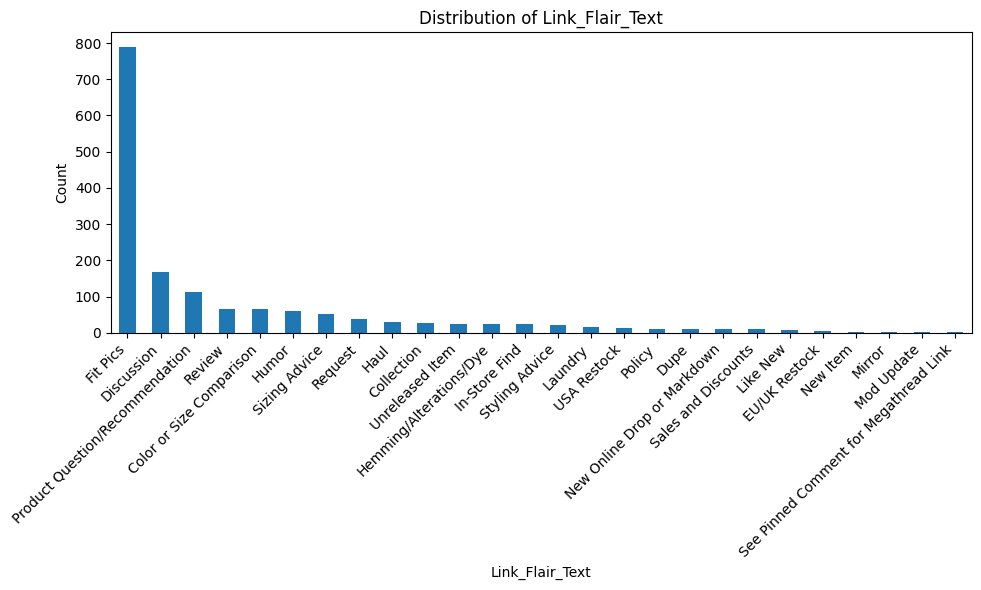

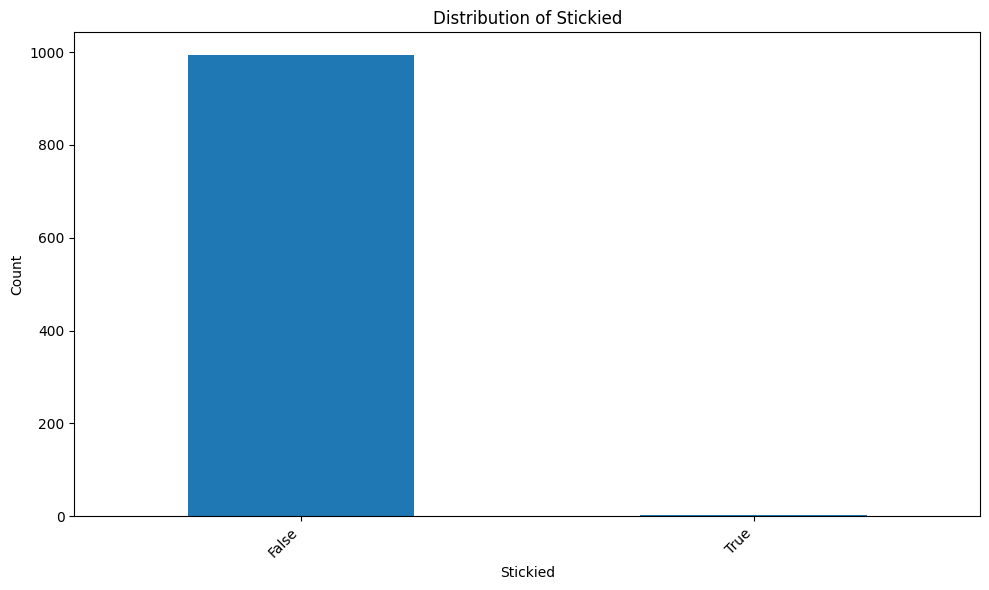

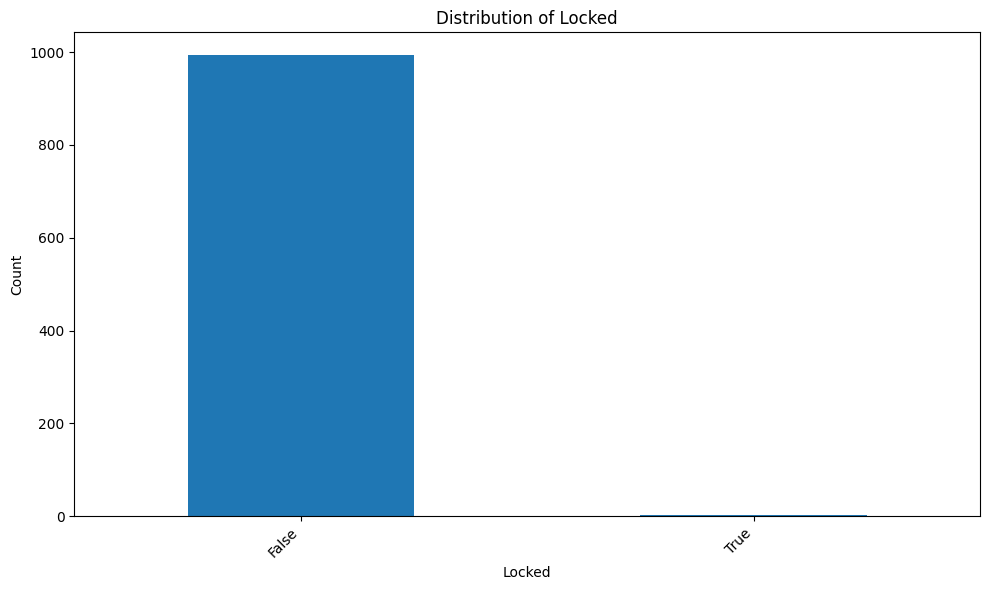

In [43]:
# Plot bar graphs of categorical columns

cat_cols = ['link_flair_text', 'stickied', 'locked']

for col in cat_cols:
    bar_graph(posts_df, col)

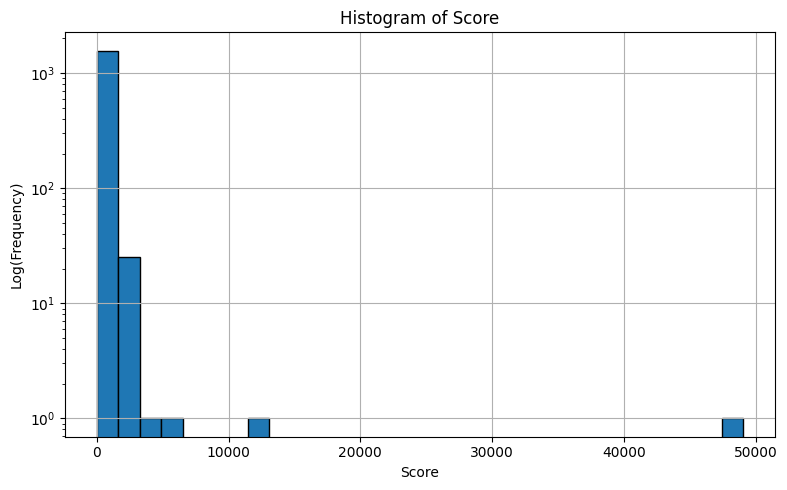

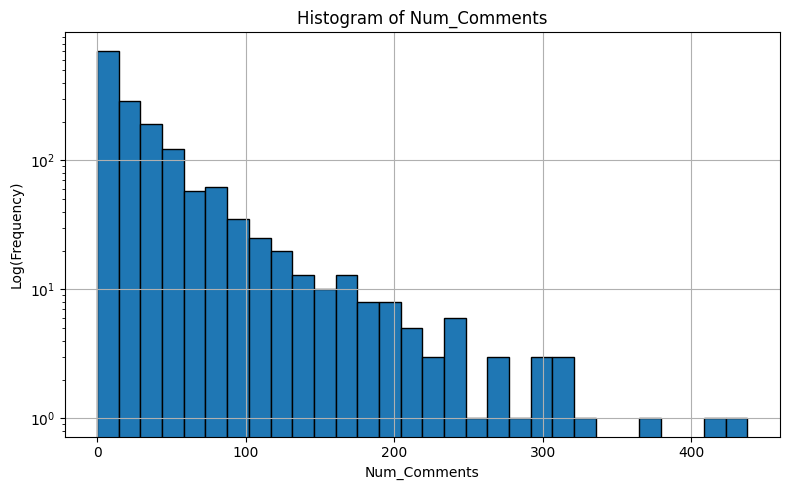

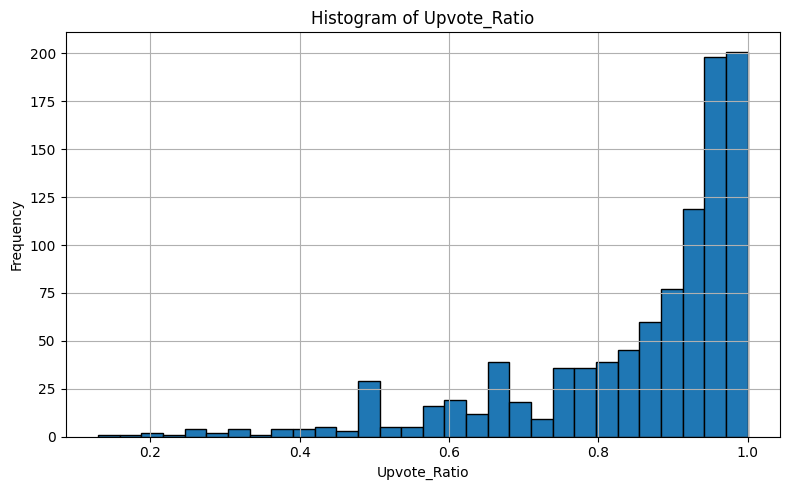

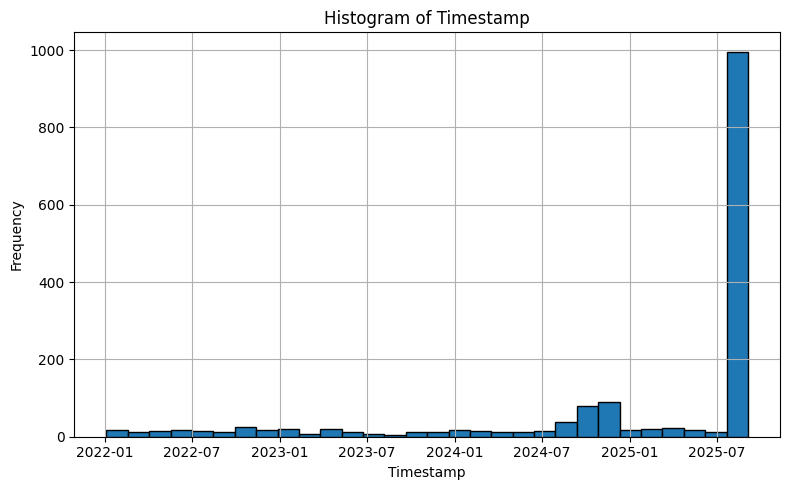

In [53]:
# Plot histograms for numeric columns

cont_cols = ['score', 'num_comments', 'upvote_ratio','timestamp']
skewed = ['score','num_comments']

for col in cont_cols:
    if col in skewed:
        histogram(posts_df, col, log = True)
    else: histogram(posts_df, col)

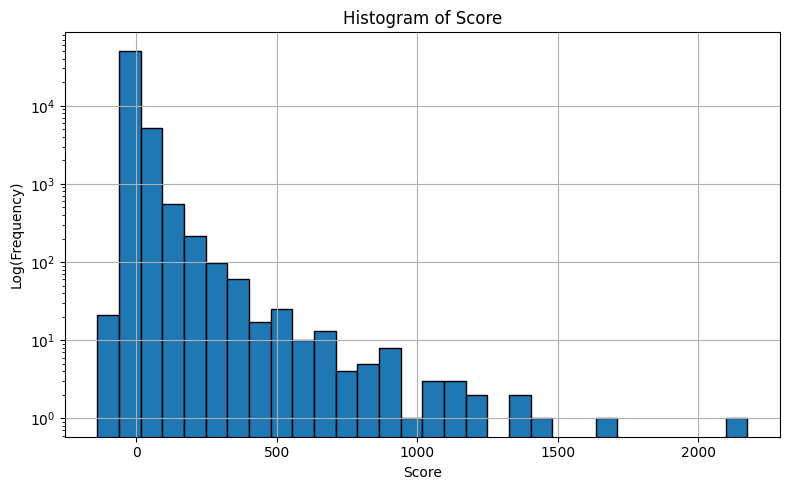

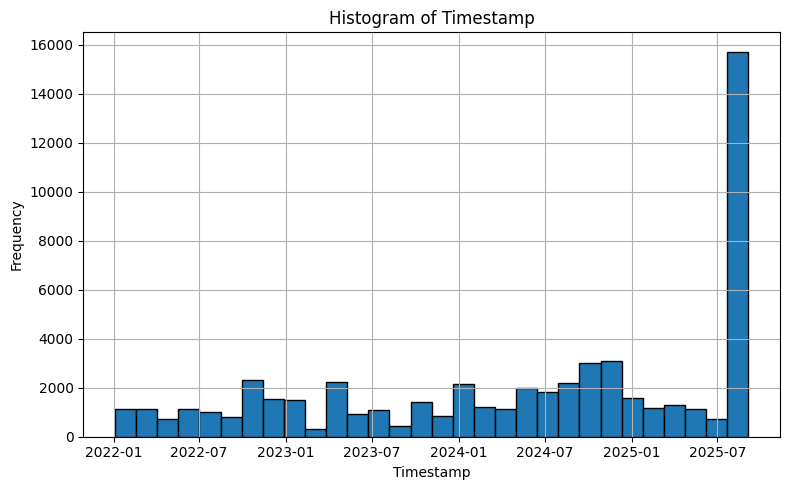

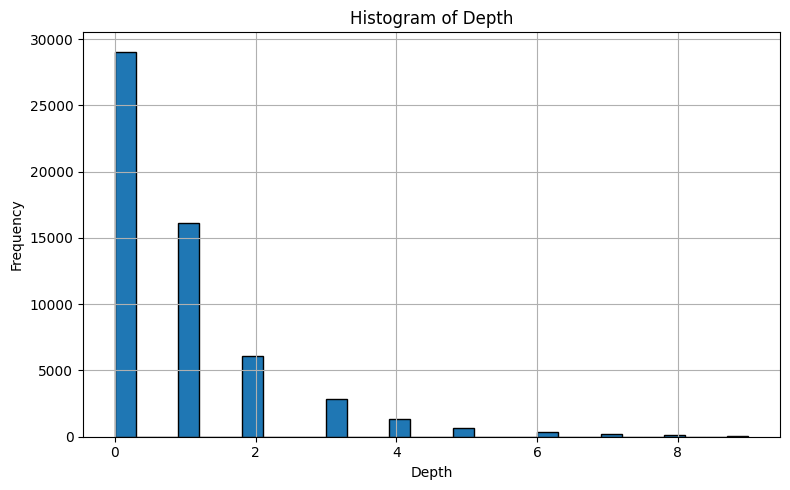

In [56]:
# Plot histograms for numeric columns

cont_cols = ['score', 'timestamp', 'depth']


for col in cont_cols:
    if col == 'score':
        histogram(comments_df, col, log = True)
    else: histogram(comments_df, col)

## NLP to Examine Full Vocabulary

In [57]:
# Obtain single dataframe with all text data

# Prepare posts
posts_stack = posts_df[["timestamp", "text"]].copy()
posts_stack["is_post"] = True

# Prepare comments
comments_stack = comments_df[["timestamp", "text"]].copy()
comments_stack["is_post"] = False

# Vertical merge
all_text_df = pd.concat([posts_stack, comments_stack], ignore_index=True)

# Drop records with null text column
all_text_df = all_text_df.dropna(subset=["text"])

examine_df('all text data', all_text_df)



Number of records in the all text data is: 58115


Number of features in the all text data is: 3

The columns in the all text data are: Index(['timestamp', 'text', 'is_post'], dtype='object')


 Other info about all text data:

<class 'pandas.core.frame.DataFrame'>
Index: 58115 entries, 0 to 58398
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  58115 non-null  datetime64[ns, UTC]
 1   text       58115 non-null  object             
 2   is_post    58115 non-null  bool               
dtypes: bool(1), datetime64[ns, UTC](1), object(1)
memory usage: 1.4+ MB


None


 Basic statistical info about all text data:



,timestamp,text,is_post
count,58115,58115,58115
unique,NaN,52084,2
top,NaN,[removed],False
freq,NaN,1504,56806
mean,2024-05-30 22:26:34.620803840+00:00,NaN,NaN
min,2022-01-03 22:10:39+00:00,NaN,NaN
25%,2023-06-18 15:15:38.500000+00:00,NaN,NaN
50%,2024-09-09 12:35:57+00:00,NaN,NaN
75%,2025-08-01 00:17:50+00:00,NaN,NaN
max,2025-09-04 05:04:23+00:00,NaN,NaN




Sample of records in the all text data:


,timestamp,text,is_post
0,2025-09-03 20:31:13+00:00,"I was shopping for a new skirt as a treat-yo-self and I saw the new Side-Pleat High-Rise Tennis Skirt. The red one priced at $98 but as it was a TYS purchase I decided to get it along with 3 other items. I got a notice that my item was shipped but awaiting carrier pick-up but that lasted so many days which is unusual for lulu. I contacted Lululemon to inquire and they said it was lost. They would refund me but seeing that the price has increased by then dollars for the skirt, I asked if they would just replace the order. The CSR said they need 100 items in order for a replacement to happen but it's available online. After some arm twisting, she put the order threw but told me that there was a good chance my order would get cancelled. I shop a lot at Lululemon and lately I feel like the customer service has been going way down. We pay a lot of money for the clothes and it just left a bad taste that I had to so much coaxing to get a reorder on a lost shipment because they use a bad carrier. Fingers crossed I actually get the celebratory skirt I ordered.",True
1,2025-09-03 20:16:03+00:00,"Sorry for the double post today but thought others would want to see the try on. I was so curious to see rockwood in person. Seems very true to online. It is a gorgeous jewel tone. The new define track that jacket was actually so much better in person. I loved it. It feels like a mix between the define and scuba with how it feels and fits. My big issue with it is there are two zippers and the bottom zipper ends in a weird spot for me. So I passed but if you get it, I’d size down. I first tried a 4 and it was pretty big so switched to a 2. I was disappointed with the WT leopard print in person. It was so hard to see and the material felt stiff. I think the sequoia WTs are much prettier so I skipped the print. Rockwood Cropped Define (4) Rockwood Align 6in shorts (2) Paired with the bra I had on — Lavender Frost Focuser Scoop neck Olive Brown / Black Define Track that jacket (2) Leopard Shift Micro Embossed Brown WT leggings (2) Rockwood Scuba joggers (xxs) My top I wore in — All it takes Club blue twist back top",True
2,2025-09-03 18:53:26+00:00,Looking for a safe crossbody bag for a European trip I’m taking next month (Italy). Has anyone traveled with these? Did you like?!,True
3,2025-09-03 18:45:38+00:00,"Fast and Free High-Rise Classic-Fit Split Short 3"" (sm) and Align tank (8) and of course a belt bag 🤍🖤",True
4,2025-09-03 18:40:03+00:00,"could anyone give me sizing advice on this? i'm 5'1, 98lbs. i was thinking maybe xxs bc i dont want to look like a snowman",True


In [58]:
# Define lemmatizer

lemmatizer = WordNetLemmatizer()

def to_wordnet_pos(penn_tag):

    '''
    Map Penn Treebank tags to WordNet POS for better lemmatization
    '''
    
    if penn_tag.startswith('J'): return wn.ADJ
    if penn_tag.startswith('V'): return wn.VERB
    if penn_tag.startswith('N'): return wn.NOUN
    if penn_tag.startswith('R'): return wn.ADV
    return wn.NOUN  # default

In [59]:
# Build lists of stopwords

# Manually curated set of non-informative tokens to exclude
CUSTOM_STOPWORDS = {'lululemon','reddit','subreddit','lol','jpeg','www'}

In [60]:
# Define custom tokenizer

def clean_tokenizer(text):
    
    """
    Clean and tokenize text data
    """

    # keep only letters and whitespace
    text = re.sub(r"[^A-Za-z\s]", " ", text)
    tokens = text.split()

    # lowercase
    tokens = [t.lower() for t in tokens]

    # filter stopwords
    tokens = [
        t for t in tokens
        if t not in ENGLISH_STOP_WORDS
        and t not in CUSTOM_STOPWORDS
        and len(t) > 2
    ]

    # Tag tokens
    pos_tags2 = nltk.pos_tag(tokens)

    # lemmatize
    tokens = [lemmatizer.lemmatize(t, to_wordnet_pos(pos)) for t, pos in pos_tags2]

    return tokens

In [61]:
# Define text vectorizer 

vectorizer = TfidfVectorizer(
    tokenizer=clean_tokenizer,  # Custom tokenizer function
    token_pattern=None,     # Tmportant when using custom tokenizer
    ngram_range=(1,2),
    max_features=1000,           # Keep the top tokens
    min_df=10,                   # Minimum document frequency of 10
    max_df=0.8,            # filter out too common terms
    lowercase=False       # tokenizer already lowercases
)

In [62]:
# Apply vectorizer

# Time the fitting
start = time.time()
tfidf_matrix = vectorizer.fit_transform(all_text_df["text"])
end = time.time()

print(f"Vectorizer fit/transform runtime: {end - start:.2f} seconds")

Vectorizer fit/transform runtime: 68.11 seconds


In [63]:
# Examine tokens

tokens = vectorizer.get_feature_names_out()

print(tokens[:1000])

['able' 'absolutely' 'account' 'account age' 'account old' 'acquire'
 'acquire karma' 'action' 'action perform' 'actual' 'actually' 'add'
 'admins' 'admins bot' 'adorable' 'advice' 'afford' 'age' 'age karma'
 'ago' 'agree' 'align' 'align legging' 'align short' 'align tank' 'aligns'
 'allow' 'alo' 'amaze' 'amazing' 'amazon' 'annoy' 'answer' 'anymore' 'app'
 'appearance' 'appearance post' 'appreciate' 'apps' 'apps intent' 'area'
 'aren' 'arm' 'armchair' 'armchair diagnose' 'article' 'article https'
 'ask' 'assume' 'athleta' 'athletic' 'auto' 'auto webp' 'automatically'
 'automatically contact' 'available' 'average' 'away' 'awesome' 'aww'
 'baby' 'backpack' 'bad' 'bag' 'ban' 'ban send' 'band' 'base' 'basic'
 'basically' 'beautiful' 'believe' 'belt' 'belt bag' 'best' 'big'
 'birthday' 'bit' 'black' 'block' 'block incoming' 'blue' 'blue twill'
 'blur' 'blur cropped' 'body' 'body clothe' 'bone' 'boob' 'bot'
 'bot action' 'bother' 'bottom' 'bra' 'brand' 'bras' 'break' 'bright'
 'bring' 'brown

## Extract subset of posts which mentioned the app

In [8]:
# Define list of words related to the app and build regex pattern

app_words = ['app','apps','mobiles','mobile','android','ios']

# Build regex pattern
pattern = r'\b(?:' + "|".join(app_words) + r')\b'

In [9]:
# Add boolean column to mark posts which mention app related words

posts_df['mentions_app'] = posts_df["text"].str.contains(pattern, case=False, na=False).astype(int)

examine_df('new posts df', posts_df)



Number of records in the new posts df is: 993


Number of features in the new posts df is: 13

The columns in the new posts df are: Index(['post_id', 'timestamp', 'author', 'title', 'text', 'score',
       'num_comments', 'link_flair_text', 'permalink', 'stickied', 'locked',
       'upvote_ratio', 'mentions_app'],
      dtype='object')


 Other info about new posts df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   post_id          993 non-null    object 
 1   timestamp        993 non-null    object 
 2   author           988 non-null    object 
 3   title            993 non-null    object 
 4   text             903 non-null    object 
 5   score            993 non-null    int64  
 6   num_comments     993 non-null    int64  
 7   link_flair_text  993 non-null    object 
 8   permalink        993 non-null    object 
 9   stickied 

None


 Basic statistical info about new posts df:



,score,num_comments,upvote_ratio,mentions_app
count,993.000000,993.000000,993.000000,993.000000
mean,70.659617,15.683787,0.854542,0.021148
std,89.459381,22.484823,0.159645,0.143950
min,0.000000,0.000000,0.140000,0.000000
25%,8.000000,4.000000,0.790000,0.000000
50%,41.000000,9.000000,0.920000,0.000000
75%,100.000000,18.000000,0.970000,0.000000
max,1005.000000,243.000000,1.000000,1.000000




Sample of records in the new posts df:


,post_id,timestamp,author,title,text,score,num_comments,link_flair_text,permalink,stickied,locked,upvote_ratio,mentions_app
0,1n72lwa,2025-09-03 02:09:03+00:00,CooperDoo422,Mystic 🔮☪️💜,"I ordered the Mystic Aligns from WMTM last week (was shocked to see they were $59!) They arrived Sunday and today it was cool enough to wear them! I paired them with my matching waist length Align Cami under my work shirt, but I also tried them with a couple other items for the sake of some photos too. 🤍HCULG Oversized Full-Zip Scuba Hoodie (xs/s) 🍇Chilled Grape Swiftly Tech Short-Sleeve Shirt Waist Length (6) ☪️Mystic Align Waist-Length Cami Tank Top A/B Cup (8) 🔮Mystic Align HR Pant 25"" (8) 🩶Heathered Silver Drop Daily Stride Quarter Socks (M)",50,5,Fit Pics,https://www.reddit.com/r/lululemon/comments/1n72lwa/mystic/,False,False,0.96,0
1,1n70wil,2025-09-03 00:49:54+00:00,painthrowaway852,Autumn Rust combos,"Java, Black, Ivory, and Espresso - love the way Autumn Rust pairs with the classics!",140,15,Fit Pics,https://www.reddit.com/r/lululemon/comments/1n70wil/autumn_rust_combos/,False,False,0.97,0
2,1n70bqt,2025-09-03 00:23:19+00:00,PleaseNoCilantro,Purple or Green,Stuck with a tough choice between purple pacing shorts or deep green so asking the fashionable people of Reddit for help. (Please ignore the non-matching button down and glaringly yellow shoes),4,8,Styling Advice,https://www.reddit.com/r/lululemon/comments/1n70bqt/purple_or_green/,False,False,0.67,0
3,1n701dx,2025-09-03 00:10:19+00:00,lameasfuq,Wunder Train Contour Fit... New Fabric?Less compression?,"I caved for the rich Sequoia color and bought a new pair of WT Contour Fit. They arrived today, and to my surprise, the fabric feels really different. Reminds me of my Base Pace leggings, which are some of my favorites, though for a different reason/intent. As far as I can tell, the material composition is the same (nylon and Lycra). Has anyone else noticed this? Could it have something to do with the new color? I haven’t bought a new pair in \~year, so maybe this is old news and affects all colorways. I really hope not!",2,2,Product Question/Recommendation,https://www.reddit.com/r/lululemon/comments/1n701dx/wunder_train_contour_fit_new_fabricless/,False,False,0.67,0
4,1n6zqss,2025-09-02 23:56:56+00:00,Scrappy52,Chicago/Rosement outlet,Has anyone been to the chicago lulu outlet recently? Trying to see if its worth going (during a trip to see family). Looking for mens clothes mostly Is there a best time of the week or best time of the year to go?,1,0,Discussion,https://www.reddit.com/r/lululemon/comments/1n6zqss/chicagorosement_outlet/,False,False,0.67,0


In [10]:
# Add boolean column to mark comments which mention app related words

comments_df['mentions_app'] = comments_df["text"].str.contains(pattern, case=False, na=False).astype(int)

examine_df('new posts df', comments_df)



Number of records in the new posts df is: 15545


Number of features in the new posts df is: 11

The columns in the new posts df are: Index(['post_id', 'comment_id', 'timestamp', 'author', 'text', 'score',
       'is_submitter', 'parent_id', 'permalink', 'depth', 'mentions_app'],
      dtype='object')


 Other info about new posts df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15545 entries, 0 to 15544
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   post_id       15545 non-null  object
 1   comment_id    15545 non-null  object
 2   timestamp     15545 non-null  object
 3   author        15362 non-null  object
 4   text          15545 non-null  object
 5   score         15545 non-null  int64 
 6   is_submitter  15545 non-null  bool  
 7   parent_id     15545 non-null  object
 8   permalink     15545 non-null  object
 9   depth         15545 non-null  int64 
 10  mentions_app  15545 non-null  int64 
dtype

None


 Basic statistical info about new posts df:



,score,depth,mentions_app
count,15545.000000,15545.000000,15545.000000
mean,4.361016,0.794918,0.004760
std,13.568250,1.118902,0.068833
min,-56.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,3.000000,1.000000,0.000000
max,904.000000,9.000000,1.000000




Sample of records in the new posts df:


,post_id,comment_id,timestamp,author,text,score,is_submitter,parent_id,permalink,depth,mentions_app
0,1n4i5ke,nbl94po,2025-08-31 01:27:30+00:00,AutoModerator,"Hello! This is a comment to let you know that you may receive a DM from the creeps who lurk this subreddit. We cannot prevent these people from DMing you, but you can! We strongly suggest that you temporarily or permanently disable new chat requests. Please see [this article](https://www.reddit.com/r/lululemon/wiki/dms/) in the wiki for instructions on how to block incoming chat requests and/or report creepy messages to mods or Reddit Admins. *I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/lululemon) if you have any questions or concerns.*",1,False,t3_1n4i5ke,https://www.reddit.com/r/lululemon/comments/1n4i5ke/a_girl_in_a_group_of_teenagers_scary_told_me_you/nbl94po/,0,0
1,1n4i5ke,nbl9wdc,2025-08-31 01:32:16+00:00,Humble-Bus3726,What kind of dog tho!,63,False,t3_1n4i5ke,https://www.reddit.com/r/lululemon/comments/1n4i5ke/a_girl_in_a_group_of_teenagers_scary_told_me_you/nbl9wdc/,0,0
2,1n4i5ke,nblb2cw,2025-08-31 01:39:23+00:00,thevffice,omg the korok!!! lovelovelove 🥹🥹🥹 where did you get it if you don't mind me asking?,47,False,t3_1n4i5ke,https://www.reddit.com/r/lululemon/comments/1n4i5ke/a_girl_in_a_group_of_teenagers_scary_told_me_you/nblb2cw/,0,0
3,1n4i5ke,nblbqh1,2025-08-31 01:43:32+00:00,Careful_Koala7995,I had a young girl with her friends tell me she liked my rain jacket the other day. I found myself wondering if it was a mean girls moment where they pretend they like something lol. But then I had to check myself - it was very sweet of her 🫶,47,False,t3_1n4i5ke,https://www.reddit.com/r/lululemon/comments/1n4i5ke/a_girl_in_a_group_of_teenagers_scary_told_me_you/nblbqh1/,0,0
4,1n4i5ke,nblbpiw,2025-08-31 01:43:22+00:00,Pd_unicorn,Love your outfit too!,10,False,t3_1n4i5ke,https://www.reddit.com/r/lululemon/comments/1n4i5ke/a_girl_in_a_group_of_teenagers_scary_told_me_you/nblbpiw/,0,0


In [11]:
# Get subset of posts that mention the app

app_posts_df = posts_df.copy()[posts_df["mentions_app"] == 1]

examine_df('posts which mention the app', app_posts_df)



Number of records in the posts which mention the app is: 21


Number of features in the posts which mention the app is: 13

The columns in the posts which mention the app are: Index(['post_id', 'timestamp', 'author', 'title', 'text', 'score',
       'num_comments', 'link_flair_text', 'permalink', 'stickied', 'locked',
       'upvote_ratio', 'mentions_app'],
      dtype='object')


 Other info about posts which mention the app:

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 24 to 980
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   post_id          21 non-null     object 
 1   timestamp        21 non-null     object 
 2   author           21 non-null     object 
 3   title            21 non-null     object 
 4   text             21 non-null     object 
 5   score            21 non-null     int64  
 6   num_comments     21 non-null     int64  
 7   link_flair_text  21 non-null     object 
 8   p

None


 Basic statistical info about posts which mention the app:



,score,num_comments,upvote_ratio,mentions_app
count,21.000000,21.000000,21.000000,21.0
mean,29.857143,88.761905,0.850000,1.0
std,34.482294,77.707081,0.120665,0.0
min,0.000000,1.000000,0.380000,1.0
25%,11.000000,18.000000,0.830000,1.0
50%,18.000000,81.000000,0.870000,1.0
75%,39.000000,163.000000,0.920000,1.0
max,161.000000,243.000000,0.960000,1.0




Sample of records in the posts which mention the app:


,post_id,timestamp,author,title,text,score,num_comments,link_flair_text,permalink,stickied,locked,upvote_ratio,mentions_app
24,1n6egvw,2025-09-02 09:00:53+00:00,lululemonmods,Tuesday Drop Discussion,"Hi everyone! Welcome to the official **Tuesday Drop Discussion**! Chat here about your reactions to the new drop, what you're planning on buying (or not buying...), and anything and everything in between! ———————— **Please keep all links and discussion around the new drop in the comments. Sort comments by new as the drop is happening to see any new releases.** ———————— **Tips and Tricks:** \- If something isn't showing up for you, search by item/color name, open the link, delete everything after product name and refresh. You may need to do this a couple of times. If that doesn't work, try clearing cache and cookies and try again. \- Edit in cart trick: Add the item you want in any size and color to your cart, and then once it's in your cart change it to color you want. \- Don't look at the What's New page, use the site search bar. \- The app is laggy, use the website. \- The new drop has generally been starting around 2:10 p.m. EST in the U.S. and just after 3 p.m. EST in Canada, but sometimes (very infrequently) it varies. \- USA and Canada pretty much always get the same new items, just as mentioned above, Canada's drop happens around 40 minutes later, thus there's no Canada thread. Good luck and happy shopping! 🥰",11,163,Discussion,https://www.reddit.com/r/lululemon/comments/1n6egvw/tuesday_drop_discussion/,True,False,0.79,1
111,1n3c7vh,2025-08-29 16:33:00+00:00,Expressoooooo,ALIGN NO-LINE 100/10,"You guys, I am SO HAPPY Lulu finally did a version with no front seam!!!! They are the perfect leggings and I need my entire collection updated ASAP. I just saw on the app that the 6” shorts are also out in no-line! Align no-line legging 28”, rainforest green, size 8 (Bra is Align v-neck, C/D cup, black)",39,6,Fit Pics,https://www.reddit.com/r/lululemon/comments/1n3c7vh/align_noline_10010/,False,False,0.90,1
152,1n24epk,2025-08-28 06:01:17+00:00,lululemonmods,Thursday WMTM Discussion,"Hi everyone! Hope you're all ready for what's hopefully an amazing WMTM drop today! Feel free to chat all things WMTM here! Is they're anything you're hoping to see turn up today? What are your thoughts on the drop? Did you end up buying anything? And more! **Since the drop happens early in the morning, please keep all WMTM links and discussion in the comments. Sort comments by new as the drop is happening to see any new WMTM releases.** **Tips and Tricks:** * The new WMTM drop in the past has happened between 7-7:15 a.m. EST in the U.S and a bit later in Canada, but sometimes it can vary. Lately it's been earlier, between 3-5AM EST. * Best methods to find new items are to search the name of the item you're looking for in the search bar and using the edit in cart trick. Sorting by ""new"" on the WMTM page is laggy and not recommended. * Edit in cart trick: Add the item in any size or color to your cart and once it's in your cart edit it to pull up the color you want. * If something isn't showing up for you when you click on the link, search by item/color name, open the link, delete everything after ""MD"" in the URL and refresh. you may need to do this a couple of times. if that doesn't work, try clearing cache and cookies and try again. * The app is laggy, use the website. Good luck all and happy shopping <3",25,81,Discussion,https://www.reddit.com/r/lululemon/comments/1n24epk/thursday_wmtm_discussion/,False,False,0.93,1
187,1n0zoya,2025-08-26 22:17:16+00:00,Unique_Requirement57,Need help identifying a bag!,"So I saw this bag on the app and wasn’t sure if it’s a lululemon bag or just a prop. if any of you know the name or if it’s a new upcoming drop, please lmk! Thank you :)",13,6,Product Question/Recommendation,https://www.reddit.com/r/lululemon/comments/1n0zoya/need_help_identifying_a_bag/,False,False,0.93,1
204,1n0gr2o,2025-08-26 09:00:59+00:00,lulul

In [12]:
# Check some sample posts

get_text_samples(app_posts_df,'text',5) 

Sample text data:


Text sample 1:


You guys, I am SO HAPPY Lulu finally did a version with no front seam!!!! They are the perfect leggings and I need my entire collection updated ASAP. I just saw on the app that the 6” shorts are also out in no-line! Align no-line legging 28”, rainforest green, size 8 (Bra is Align v-neck, C/D cup, black)



Text sample 2:


Hi everyone! Hope you're all ready for what's hopefully an amazing WMTM drop today! Feel free to chat all things WMTM here! Is they're anything you're hoping to see turn up today? What are your thoughts on the drop? Did you end up buying anything? And more! **Since the drop happens early in the morning, please keep all WMTM links and discussion in the comments. Sort comments by new as the drop is happening to see any new WMTM releases.** **Tips and Tricks:** * The new WMTM drop in the past has happened between 7-7:15 a.m. EST in the U.S and a bit later in Canada, but sometimes it can vary. Lately it's been earlier, between 3-5AM 

In [13]:
# Get subset of comments that mention the app

app_comments_df = comments_df.copy()[comments_df["mentions_app"] == 1]

examine_df('comments which mention the app', app_comments_df)



Number of records in the comments which mention the app is: 74


Number of features in the comments which mention the app is: 11

The columns in the comments which mention the app are: Index(['post_id', 'comment_id', 'timestamp', 'author', 'text', 'score',
       'is_submitter', 'parent_id', 'permalink', 'depth', 'mentions_app'],
      dtype='object')


 Other info about comments which mention the app:

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 122 to 15436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   post_id       74 non-null     object
 1   comment_id    74 non-null     object
 2   timestamp     74 non-null     object
 3   author        74 non-null     object
 4   text          74 non-null     object
 5   score         74 non-null     int64 
 6   is_submitter  74 non-null     bool  
 7   parent_id     74 non-null     object
 8   permalink     74 non-null     object
 9   depth         74 non-

None


 Basic statistical info about comments which mention the app:



,score,depth,mentions_app
count,74.000000,74.000000,74.0
mean,5.310811,1.081081,1.0
std,9.328004,1.321651,0.0
min,-5.000000,0.000000,1.0
25%,1.000000,0.000000,1.0
50%,2.000000,1.000000,1.0
75%,4.750000,2.000000,1.0
max,62.000000,7.000000,1.0




Sample of records in the comments which mention the app:


,post_id,comment_id,timestamp,author,text,score,is_submitter,parent_id,permalink,depth,mentions_app
122,1mk91sf,n7wns22,2025-08-10 07:47:03+00:00,Jcismyfather,I noticed lulu did drop some fun color on the men side recently. You can go on the app/website to use the filter to see if men + women products have matching colors.,2,False,t3_1mk91sf,https://www.reddit.com/r/lululemon/comments/1mk91sf/matching_sets_as_a_man/n7wns22/,0,1
387,1mo4xa4,n8a7zwf,2025-08-12 13:13:15+00:00,fawnnose1,Does anyone know when the lulu app will release these??,1,False,t3_1mo4xa4,https://www.reddit.com/r/lululemon/comments/1mo4xa4/blue_twill_align_leggings_28_and_wundertrain_bra/n8a7zwf/,0,1
551,1mey1ld,n6hfblf,2025-08-02 05:59:23+00:00,lululemon-ModTeam,"Your post has been removed per Rule 1. This includes unsolicited feedback about body/clothing appearance, posting screenshots of resale apps with the intent to shame or expose resellers (even if the name is blurred or cropped), and armchair diagnoses. Repeat offenses can result in a temporary or permanent ban. Send a modmail if you have further questions.",1,False,t1_n6cw5gm,https://www.reddit.com/r/lululemon/comments/1mey1ld/chilled_grape_combos/n6hfblf/,1,1
738,1mvw5dh,n9tl7zb,2025-08-21 01:57:05+00:00,SpideyWhiplash,"Thank you!💯 I was scrolling through the new T and S. Couldn't find anything. Now, I'm curious are all the additional perks in the Pinnacle Membership only accessable through their Apple App.🤔 Or will they apply to us sidelined Website users. Because as most Android users know....we get left out in the cold too much.🫩",24,False,t1_n9t77d2,https://www.reddit.com/r/lululemon/comments/1mvw5dh/membership_changes/n9tl7zb/,4,1
948,1mjs7jp,n7l0ha4,2025-08-08 11:35:33+00:00,bruinshorty,The app or website for my bank and cc have a cash back offers section and you can scroll through and just click on the various deals to opt in.,2,False,t1_n7jxwrq,https://www.reddit.com/r/lululemon/comments/1mjs7jp/thursday_wmtm_discussion/n7l0ha4/,4,1


In [14]:
# Check some sample comments

get_text_samples(app_comments_df,'text',5) 

Sample text data:


Text sample 1:


Mobile, Alabama Crime there has always been a bit of a problem. Bold though I must say.



Text sample 2:


Your post has been removed per Rule 1. This includes unsolicited feedback about body/clothing appearance, posting screenshots of resale apps with the intent to shame or expose resellers (even if the name is blurred or cropped), and armchair diagnoses. Repeat offenses can result in a temporary or permanent ban. Send a modmail if you have further questions.



Text sample 3:


The app or website for my bank and cc have a cash back offers section and you can scroll through and just click on the various deals to opt in.



Text sample 4:


https://preview.redd.it/v0iw19e92ulf1.jpeg?width=1179&format=pjpg&auto=webp&s=5cd54414c9572f9327a80ce6a8804881011eb1e6 Hey girl, I’m wondering which chart you’re reading from? This is directly from the app. I’m 5’2”, 110lbs, 23.5” waist, and 34” hips. Although I can technically fit into a 2 in leggings, a 4 is m

In [15]:
# Get list of links to posts that mention the app

links = list(app_posts_df['permalink'])

for i, link in enumerate(links):
    print(f"\nPost {i} url: {link}\n")


Post 0 url: https://www.reddit.com/r/lululemon/comments/1n6egvw/tuesday_drop_discussion/


Post 1 url: https://www.reddit.com/r/lululemon/comments/1n3c7vh/align_noline_10010/


Post 2 url: https://www.reddit.com/r/lululemon/comments/1n24epk/thursday_wmtm_discussion/


Post 3 url: https://www.reddit.com/r/lululemon/comments/1n0zoya/need_help_identifying_a_bag/


Post 4 url: https://www.reddit.com/r/lululemon/comments/1n0gr2o/tuesday_drop_discussion/


Post 5 url: https://www.reddit.com/r/lululemon/comments/1mxluq5/what_are_these_pants/


Post 6 url: https://www.reddit.com/r/lululemon/comments/1mx7rrb/app_not_showing_recent_purchases_on_first_page/


Post 7 url: https://www.reddit.com/r/lululemon/comments/1mw2vsw/thursday_wmtm_discussion/


Post 8 url: https://www.reddit.com/r/lululemon/comments/1mvmn7c/back_in_the_gym_with_the_nulux_racerback_run_tank/


Post 9 url: https://www.reddit.com/r/lululemon/comments/1mud6dy/tuesday_drop_discussion/


Post 10 url: https://www.reddit.com/r/lulu